# Fitting an Individual Power Spectrum

In this example, we will fit an individual power spectrum model.

## Load Python libraries

First, we will load the Python modules we need for this example.

In [25]:
# Import some useful standard library modules
import os
from pathlib import Path

# Import some general scientific python libraries
import numpy as np
import pandas as pd

# Import the parameterization model object
from fooof import FOOOF

# Import functions to visualize flattened power spectrum
from fooof.plts.spectra import plot_spectrum
from fooof.sim.gen import gen_aperiodic

# Import functions to examine frequency-by-frequency error of model fits
from fooof.analysis.error import compute_pointwise_error_fm

### Check specparam version

In [2]:
import fooof
print(fooof.__version__)

1.0.0


## Set data path

Next, we can set the path to where the data is available.

In [3]:
# Check working directory
os.getcwd()

'/Users/brendan.ostlund/Desktop/DevelopmentalDemo/Python'

In [4]:
# Set the data path to load from
data_path = Path('../Data/')

## Load invididual PSD

Load CSV files, including:
- `freqs.csv`, which contains a vector of frequencies
- `indvPSD.csv`, which contains the power values for an individual power spectrum

In [5]:
# Load data
freqs = np.ravel(pd.read_csv(data_path / "freqs.csv"))
spectrum = np.ravel(pd.read_csv(data_path / "indv.csv"))[1:101]  

In [6]:
# Check shapes of loaded data
print(freqs.shape)
print(spectrum.shape)

(99,)
(99,)


## Parameterize a power spectrum

Now we can parameterize our power spectrum!

In [7]:
# Initialize a model object for spectral parameterization, with some settings 
fm = FOOOF(peak_width_limits = [2, 8], max_n_peaks = 6, min_peak_height = 0.05, verbose = False)  

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          2.1629, 1.9838                                          
                                                                                                  
                                       2 peaks were found:                                        
          

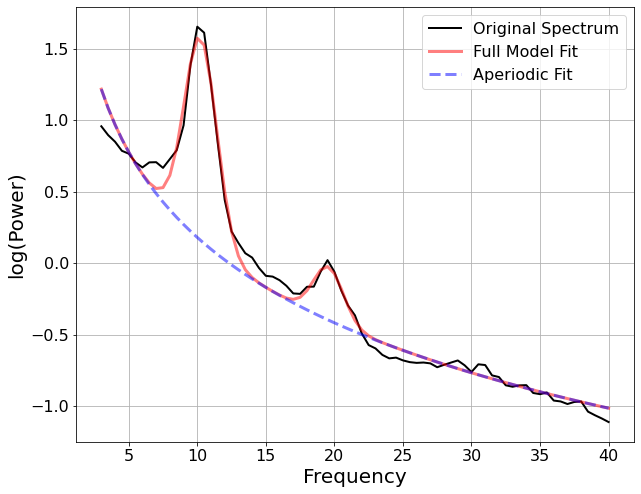

In [8]:
# Fit individual PSD over 3-40 Hz range      
fm.report(freqs, spectrum, [3, 40])

In [9]:
# Save out a copy of the model fit report
fm.save_report('INDV_demo', file_path= '../Output')

# The following line can also be used to save out the model plot
#fm.plot(save_fig = True, file_name = 'INDV_demo', file_path = '../Output')

## Access model fit information

All of the model fit information is saved to the model object. 

Note that all attributes learned in the model fit process have a trailing underscore. 

In [10]:
# Access the model fit parameters from the model object
print('Aperiodic parameters: \n', fm.aperiodic_params_, '\n')
print('Peak parameters: \n', fm.peak_params_, '\n')
print('Goodness of fit:')
print('Error - ', fm.error_)
print('R^2   - ', fm.r_squared_, '\n')
print('Number of fit peaks: \n', fm.n_peaks_)

Aperiodic parameters: 
 [2.1629177  1.98379764] 

Peak parameters: 
 [[10.23978701  1.39291459  2.38094088]
 [19.5665069   0.37190755  2.19414183]] 

Goodness of fit:
Error -  0.05826545024516166
R^2   -  0.9891330639339952 

Number of fit peaks: 
 2


## Extract periodic and aperiodic parameters

Another way to access model fit parameters is to use the `get_params` method, which can be used to access model fit attributes. 

In [11]:
# Extract aperiodic and periodic parameter
aps = fm.get_params('aperiodic_params')
peaks = fm.get_params('peak_params')

In [12]:
# Extract goodness of fit information 
err = fm.get_params('error')
r2s = fm.get_params('r_squared')

In [13]:
# Extract specific parameters
exp = fm.get_params('aperiodic_params', 'exponent')   
cfs = fm.get_params('peak_params', 'CF')

In [14]:
# Print out a custom parameter report
template = ("With an error level of {error:1.2f}, specparam fit an exponent "
            "of {exponent:1.2f} and peaks of {cfs:s} Hz.")
print(template.format(error = err, exponent = exp, 
                      cfs = ' & '.join(map(str, [round(CF, 2) for CF in cfs]))))

With an error level of 0.06, specparam fit an exponent of 1.98 and peaks of 10.24 & 19.57 Hz.


## Plot flattened power spectrum
It may be useful to plot a flattened power spectrum, with the aperiodic fit removed.

In [23]:
# Set whether to plot in log-log space
plt_log = False

In [26]:
# Do an initial aperiodic fit - a robust fit, that excludes outliers
init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))

# Recompute the flattened spectrum using the initial aperiodic fit
init_flat_spec = fm.power_spectrum - init_ap_fit

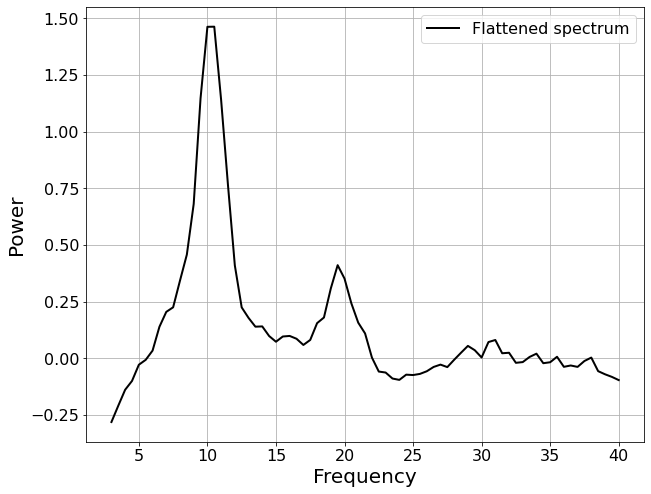

In [28]:
# Plot the flattened the power spectrum
plot_spectrum(fm.freqs, init_flat_spec, plt_log, label = 'Flattened spectrum', color = 'black')

## Save files

The model object also has I/O utilities for saving and reloading data. 

The `save` method can be used to save out data from the object, specifying which information to save. 

In [29]:
# Save out the settings used to fit the model
fm.save('fit_settings', save_settings = True, file_path= '../Output')

In [17]:
# Save out the results of the model fit
fm.save('fit_results', save_results = True, file_path= '../Output')

In [31]:
# Save out a copy of the data used to fit the model
fm.save('fit_data', save_data = True, file_path= '../Output')

Another option is to save out data as a .csv rather than the default .json file format, the preferred format for specparam model outputs.   

In [26]:
# Save out aperiodic parameter results
aper = pd.DataFrame(aps).transpose()
aper.columns = ['offset', 'exponent']
aper.to_csv('../Output/INDV_demo_aper.csv')

In [27]:
# Save out periodic parameter results
per = pd.DataFrame(peaks)
per.columns = ['CF', 'PW', 'BW']
per.to_csv('../Output/INDV_demo_per.csv')

In [28]:
# Save out model fit results
fit = pd.DataFrame([r2s, err]).transpose()
fit.columns = ['r2', 'error']
fit.to_csv('../Output/INDV_demo_fits.csv')

## Reload 

We can also check our saved out results by reloading them. 

In [18]:
# Reload the saved out model result
nfm = FOOOF()
nfm.load('fit_results', file_path= '../Output')

In [19]:
# Check the results of the reloaded model fit
nfm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          2.1629, 1.9838                                          
                                                                                                  
                                       2 peaks were found:                                        
          

## Frequency-by-frequency error
It can be useful to plot frequency-by-frequency error of the model fit, to identify where in frequency space the spectrum is (or is not) being fit well. When fitting individual spectrum, this can be accomplished using the `compute_pointwise_error_fm` function.

In this case, we can see that error fluctuates around 0.05, which is the same as the mean absolute error for the model (MAE). There are points in the spectrum where the model fit is somewhat poor, particularly < 4 Hz, around 6-9 Hz, and around 14 Hz. Further considerations may be necessary for this model fit.

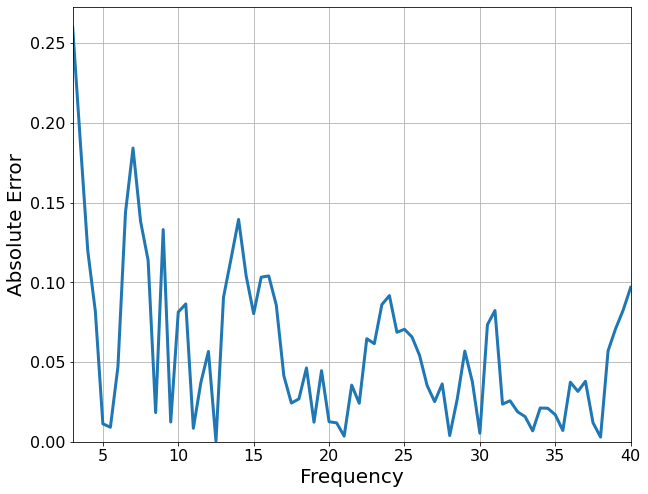

In [20]:
# Plot frequency-by-frequency error 
compute_pointwise_error_fm(fm, plot_errors = True)

In [21]:
# Return the frequency-by-frequency errors
errs_fm = compute_pointwise_error_fm(fm, plot_errors= False, return_errors = True)
errs_fm

array([0.25967498, 0.18883009, 0.1197245 , 0.08188237, 0.01127057,
       0.00913172, 0.04708956, 0.14374249, 0.18415733, 0.13823175,
       0.11382716, 0.01832904, 0.13305786, 0.01239453, 0.08134444,
       0.08644473, 0.00847309, 0.03722825, 0.05664604, 0.00039514,
       0.09064834, 0.11478865, 0.13940562, 0.10411944, 0.08034126,
       0.10319903, 0.10398723, 0.08567622, 0.04142708, 0.02428387,
       0.02689197, 0.04628511, 0.01229682, 0.04459547, 0.01257452,
       0.01187636, 0.00357017, 0.03553944, 0.02416217, 0.06464537,
       0.06152195, 0.08600514, 0.09166783, 0.06866889, 0.07054325,
       0.06568645, 0.05418527, 0.03529703, 0.02515782, 0.03630001,
       0.00392032, 0.02688616, 0.05685445, 0.03767857, 0.00538077,
       0.07340741, 0.08228643, 0.02362313, 0.02572322, 0.01881728,
       0.01574946, 0.00684069, 0.02119483, 0.02103028, 0.01694277,
       0.00710105, 0.03738228, 0.03160477, 0.03793353, 0.01199609,
       0.00296019, 0.05705409, 0.07093905, 0.08254338, 0.09683

In [22]:
# Note that the average of this error is the same as the global error stored
print('Average freq-by-freq error:\t {:1.3f}'.format(np.mean(errs_fm)))
print('FOOOF model fit error: \t\t {:1.3f}'.format(fm.error_))

Average freq-by-freq error:	 0.058
FOOOF model fit error: 		 0.058
